In [1]:
import pandas as pd
import numpy as np

from collections import Counter, OrderedDict

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

%matplotlib
%matplotlib inline

plt.style.use('ggplot')
import seaborn as sns


pd.set_option('display.max_rows', 500)

Using matplotlib backend: Qt5Agg


In [2]:
import spacy
nlp = spacy.load('en')

In [3]:
root = '../'

dataset_f = root + 'data/interim/num_fh.csv'

In [4]:
df = pd.read_csv(dataset_f)

In [5]:
data_groups = df.groupby(df['id'])

In [6]:
len(data_groups)

9832

In [120]:
dataset = {}
unique_references = []
i = 0
for scene in tqdm_notebook(data_groups):
    # getting the scene from each group and reindexing inner index in every group
    sc = scene[1].reset_index()

    words_ind = sc['index'].tolist()
    lines_ind = sc['line_ind'].tolist()
    speakers = sc['speaker'].tolist()

    target = sc[sc['head'] != '-']
    target_words = target['word'].tolist()
    if len(target_words) == 0:
        assert False 
    
    ref = sc[sc['referred'] != '-']
    if len(ref) > 1 and 'REFERENCE' not in target['head'].values:
        assert False
    
    lemma_ref = [nlp(unicode(x.decode('utf-8')))[:].lemma_ for x in ref.word.values]
    if len(set(lemma_ref)) > 1:
        unique_references.append(scene)
    
    dataset[sc['id'].values[0]] = {'num_lines': len(set(lines_ind)), 'num_words': len(sc),
                        'target': target, 'reference': ref, 'words_in_sentence': Counter(lines_ind).values()}

In [121]:
len(unique_references)

177

In [129]:
unq = pd.concat([x[1] for x in unique_references])

In [131]:
unq.to_csv('/home/nlp/lazary/workspace/thesis/num_fused_head/data/processed/multi-ref.csv', encoding='utf-8')

# Dataset Statistics

In [70]:
latex_stats = []

In [71]:
metrics_f = OrderedDict([('min', np.min), ('max', np.max), ('mean', np.mean),
            ('std', np.std), ('median', np.median)])

## General corpus stats

In [10]:
print 'dataset size: {0}'.format(len(dataset))

dataset size: 9832


#### Number of lines in a Scene

In [72]:
scene_lines = [scene['num_lines'] for scene in dataset.values()]
for name, f in metrics_f.iteritems():
    print '{0} number of lines in a scene: {1}'.format(name, f(scene_lines))

min number of lines in a scene: 1
max number of lines in a scene: 28
mean number of lines in a scene: 6.21440195281
std number of lines in a scene: 5.41826650776
median number of lines in a scene: 4.0


#### Words in a Scene

In [73]:
num_words_scene = [scene['num_words'] for scene in dataset.values()]
vals = []
for name, f in metrics_f.iteritems():
    val = f(num_words_scene)
    print '{0} number of words in a scene: {1}'.format(name, val)
    vals.append(val)

min number of words in a scene: 5
max number of words in a scene: 1568
mean number of words in a scene: 104.064890155
std number of words in a scene: 103.12059079
median number of words in a scene: 70.0


#### Words in sentence (by speaker)

In [13]:
words_by_speaker = np.hstack([scene['words_in_sentence'] for scene in dataset.values()])
for name, f in metrics_f.iteritems():
    print '{0} number of words in a sentence: {1}'.format(name, f(words_by_speaker))

min number of words in a sentence: 1
max number of words in a sentence: 934
mean number of words in a sentence: 16.7457610475
std number of words in a sentence: 20.9307918312
median number of words in a sentence: 11.0


## Target stats

In [14]:
y_dist = Counter([scene['target']['head'].values[0] for scene in dataset.values()])

In [15]:
y_dist

Counter({'AGE': 1075,
         'CURRENCY': 388,
         'OTHER': 2265,
         'PEOPLE': 807,
         'REFERENCE': 4598,
         'TIME': 214,
         'YEAR': 485})

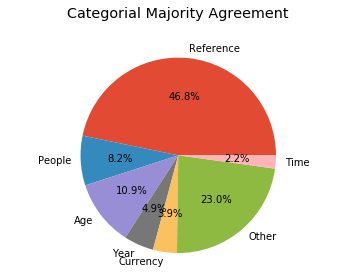

In [132]:
# none_ag = Counter([c['ans'][0][0] for c in answers.values() if len(set(e[0] for e in c['ans'])) == 3])
labels = 'Reference', 'People', 'Age', 'Year', 'Currency', 'Other', 'Time'
fig_agg, ax_agg = plt.subplots()

ax_agg.pie(y_dist.values(), labels=labels, autopct='%1.1f%%')
ax_agg.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Categorial Majority Agreement', y=1.1)
# my_dpi=1200
# plt.savefig('../reports/figures/class_dist.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.savefig('../reports/figures/class_dist.png', bbox_inches='tight', dpi=200)
plt.show()

In [17]:
num_target_words = [len(scene['target']['head'].values) for scene in dataset.values()]
for name, f in metrics_f.iteritems():
    print '{0} number of target words in a scene: {1}'.format(name, f(num_target_words))

min number of target words in a scene: 1
max number of target words in a scene: 9
mean number of target words in a scene: 1.05614320586
std number of target words in a scene: 0.363483864523
median number of target words in a scene: 1.0


### Target Stats

In [18]:
target_words = [x['target'].word.values.tolist() for x in dataset.values()]

In [19]:
target_c = Counter(len(x) for x in target_words)
target_w = Counter([' '.join(x) for x in target_words])

#### Target Lengths

In [20]:
target_c

Counter({1: 9516, 2: 152, 3: 134, 4: 7, 5: 15, 6: 3, 7: 2, 9: 3})

#### Most common target words

In [21]:
def bar_plot(objects, vals, y_pos, title, x_label, y_label):
    plt.bar(y_pos, vals, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

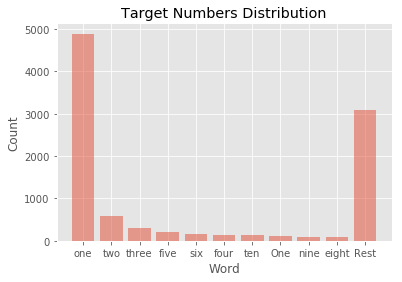

In [22]:
targets = target_w.most_common(n=10)
target_least_common = sum([x[1] for x in reversed(target_w.most_common()[-(len(target_w) - len(targets)):])])

words_vals = [t[1] for t in targets] + [target_least_common]
words = [t[0] for t in targets] + ['Rest']
y_pos = np.arange(len(words_vals))
bar_plot(words, words_vals, y_pos, 'Target Numbers Distribution', 'Word', 'Count')

In [23]:
targets

[('one', 4888),
 ('two', 593),
 ('three', 309),
 ('five', 205),
 ('six', 160),
 ('four', 148),
 ('ten', 136),
 ('One', 112),
 ('nine', 95),
 ('eight', 91)]

In [24]:
singletons = 0
for w, c in target_w.iteritems():
    if c == 1:
        singletons += 1
print singletons

450


### Reference Stats

In [25]:
references = {k: v for k, v in dataset.iteritems() if len(v['reference']) > 0}

In [26]:
len(references)

4598

In [27]:
dataset.items()[2][1]['reference']

,index,id,show_id,scene_id,line_ind,word_ind,speaker,word,head,referred
3,131,2,75,1,0,3,FBI Agent Nicole Scott,crooler,-,(REFERRED_0)
12,140,2,75,1,1,7,Jess Mastriani,crooler,-,(REFERRED_0)
36,164,2,75,1,2,17,FBI Agent Nicole Scott,crooler,-,(REFERRED_0)
49,177,2,75,1,3,9,Jess Mastriani,croolers,-,(REFERRED_0)


In [28]:
reference_words = []
for row in tqdm_notebook(references.values()):
    reference = []
    ref = ''
    for ind, w in row['reference'].iterrows():
        if not w.referred.endswith(')'):
            ref += ' ' + w.word
        
        if w.referred.endswith(')'):
            ref += ' ' + w.word
            reference.append(ref.strip())
            ref = ''
    reference_words.append(reference)

In [29]:
reference_words[:10]

[['kid'],
 ['crooler', 'crooler', 'crooler', 'croolers'],
 ['muffin', 'muffin'],
 ['Airedale'],
 ['side', 'side'],
 ['blackout'],
 ['endings'],
 ['man', 'man'],
 ['Dongs', 'dongs', 'Dongs'],
 ['Dongs', 'Dongs']]

#### number of referred answers in a scene

In [30]:
num_ref_ans = [len(x) for x in reference_words]
for name, f in metrics_f.iteritems():
    print '{0} targets: {1}'.format(name, f(num_ref_ans))

min targets: 1
max targets: 12
mean targets: 1.51413658112
std targets: 1.068406382
median targets: 1.0


In [31]:
num_ref_ans_c = Counter(num_ref_ans)
print num_ref_ans_c

Counter({1: 3217, 2: 890, 3: 269, 4: 95, 5: 59, 6: 35, 7: 14, 8: 9, 9: 4, 11: 3, 12: 2, 10: 1})


In [32]:
float(sum([x[1] for x in num_ref_ans_c.most_common(1)])) / sum(num_ref_ans_c.values())

0.6996520226185298

#### number of unique referred answers

In [79]:
temp = nlp(u'hello there')

In [81]:
temp[:].lemma_

u'hello there'

In [88]:
lemma_refs = []
for x in reference_words:
    words = []
    for t in x:
        words.append(nlp(unicode(t.decode('utf-8')))[:].lemma_)
    lemma_refs.append(words)

In [89]:
lemma_refs

[[u'kid'],
 [u'crooler', u'crooler', u'crooler', u'crooler'],
 [u'muffin', u'muffin'],
 [u'airedale'],
 [u'side', u'side'],
 [u'blackout'],
 [u'ending'],
 [u'man', u'man'],
 [u'dong', u'dong', u'dong'],
 [u'dong', u'dong'],
 [u'dong'],
 [u'thousand'],
 [u'blonde'],
 [u'rotisserie'],
 [u'hemroid'],
 [u'life'],
 [u'neighborhood'],
 [u'comb', u'comb'],
 [u'hobby'],
 [u'chick'],
 [u'car', u'car', u'car', u'car', u'car', u'car', u'car'],
 [u'baby'],
 [u'year'],
 [u'bath', u'bath'],
 [u'reason'],
 [u'bastard'],
 [u'girlfriend'],
 [u'movie'],
 [u'people'],
 [u'dress'],
 [u'basket'],
 [u'pound'],
 [u'job'],
 [u'dream', u'dream'],
 [u'sam', u'sam', u'sam'],
 [u'award'],
 [u'tale'],
 [u'ogre'],
 [u'present'],
 [u'statue'],
 [u'piece'],
 [u'reputation', u'reputation'],
 [u'gun', u'gun'],
 [u'telekinetic'],
 [u'partridge', u'partridge'],
 [u'opera', u'opera', u'meistersinger'],
 [u'transceiver'],
 [u'gun', u'gun'],
 [u'arm'],
 [u'suicide'],
 [u'man'],
 [u'dinner'],
 [u'hang'],
 [u'jacket'],
 [u'ec

In [90]:
num_unique_ref = [len(set(x)) for x in lemma_refs]
for name, f in metrics_f.iteritems():
    print '{0} targets: {1}'.format(name, f(num_unique_ref))

min targets: 1
max targets: 5
mean targets: 1.04371465855
std targets: 0.235133601825
median targets: 1.0


In [34]:
Counter(num_unique_ref)

Counter({1: 4282, 2: 292, 3: 19, 4: 4, 5: 1})

In [91]:
Counter(num_unique_ref)

Counter({1: 4421, 2: 159, 3: 13, 4: 4, 5: 1})

In [134]:
sum(num_unique_ref)

4799

In [92]:
[(set(x)) for x in lemma_refs]

[{u'kid'},
 {u'crooler'},
 {u'muffin'},
 {u'airedale'},
 {u'side'},
 {u'blackout'},
 {u'ending'},
 {u'man'},
 {u'dong'},
 {u'dong'},
 {u'dong'},
 {u'thousand'},
 {u'blonde'},
 {u'rotisserie'},
 {u'hemroid'},
 {u'life'},
 {u'neighborhood'},
 {u'comb'},
 {u'hobby'},
 {u'chick'},
 {u'car'},
 {u'baby'},
 {u'year'},
 {u'bath'},
 {u'reason'},
 {u'bastard'},
 {u'girlfriend'},
 {u'movie'},
 {u'people'},
 {u'dress'},
 {u'basket'},
 {u'pound'},
 {u'job'},
 {u'dream'},
 {u'sam'},
 {u'award'},
 {u'tale'},
 {u'ogre'},
 {u'present'},
 {u'statue'},
 {u'piece'},
 {u'reputation'},
 {u'gun'},
 {u'telekinetic'},
 {u'partridge'},
 {u'meistersinger', u'opera'},
 {u'transceiver'},
 {u'gun'},
 {u'arm'},
 {u'suicide'},
 {u'man'},
 {u'dinner'},
 {u'hang'},
 {u'jacket'},
 {u'eclair'},
 {u'coup'},
 {u'hour'},
 {u'community'},
 {u'drink'},
 {u'eclair'},
 {u'car'},
 {u'yabba'},
 {u'punchbowl'},
 {u'rule'},
 {u'love'},
 {u'gag', u'kimono', u'rope'},
 {u'buckle'},
 {u'test'},
 {u'joe'},
 {u'word'},
 {u'keepin'},
 {u

### References heads pos-tags

In [35]:
pos_c = []
for ref in reference_words:
    refs = list(set(ref))
    ref_nlp = nlp(unicode(refs[0].decode('utf-8')))
    pos_c.append((ref_nlp[0].pos_, ref_nlp[0].text))

In [36]:
Counter([x[0] for x in pos_c])

Counter({u'ADJ': 83,
         u'ADP': 5,
         u'ADV': 7,
         u'DET': 1,
         u'INTJ': 5,
         u'NOUN': 4049,
         u'NUM': 11,
         u'PRON': 25,
         u'PROPN': 190,
         u'PUNCT': 1,
         u'SYM': 1,
         u'VERB': 219,
         u'X': 1})

In [37]:
[x for x in pos_c if x[0] == 'VERB'][:20]

[(u'VERB', u'hanging'),
 (u'VERB', u'drink'),
 (u'VERB', u'show'),
 (u'VERB', u'cause'),
 (u'VERB', u'drink'),
 (u'VERB', u'suspect'),
 (u'VERB', u'rides'),
 (u'VERB', u'features'),
 (u'VERB', u'rise'),
 (u'VERB', u'thought'),
 (u'VERB', u'slip'),
 (u'VERB', u'act'),
 (u'VERB', u'woodshed'),
 (u'VERB', u'lead'),
 (u'VERB', u'suspect'),
 (u'VERB', u'covers'),
 (u'VERB', u'drink'),
 (u'VERB', u'look'),
 (u'VERB', u'covers'),
 (u'VERB', u'kiss')]

### Target-Ref relations

#### target-ref min word distance

In [38]:
min_d = lambda a, b: min([abs(x - a) for x in b])

target_ref_dists = []
mvals = []
for k, g in tqdm_notebook(data_groups):
    try:
        if g[g['head'] != '-']['head'].values[0] != 'REFERENCE':
            continue
    except:
        assert False
    head_ind = g[g['head'] != '-'].index[0]
    refs = []
    for idx, row in g[g['referred'] != '-'].iterrows():
        if not row['referred'].startswith('('): continue
        refs.append(idx)
    if len(refs) == 0:
        assert False
    
    mv = min_d(head_ind, refs)
    if mv == 1:
        print g.head(1).id
    target_ref_dists.append((head_ind, refs))

416652    4701
Name: id, dtype: int64



In [39]:
min_ref_tar_word_dist = [min_d(a, b) for a, b in target_ref_dists]
for name, f in metrics_f.iteritems():
    print '{0} target length: {1}'.format(name, f(min_ref_tar_word_dist))

min target length: 1
max target length: 240
mean target length: 10.742061766
std target length: 10.1395234551
median target length: 8.0


In [40]:
min_ref_tar_word_c = Counter(min_ref_tar_word_dist)
print min_ref_tar_word_c

print float(sum([x[1] for x in min_ref_tar_word_c.most_common(20)])) / sum(min_ref_tar_word_c.values())

Counter({6: 451, 4: 427, 5: 420, 7: 409, 8: 317, 3: 289, 9: 273, 10: 237, 11: 225, 12: 162, 13: 153, 2: 147, 14: 133, 16: 105, 15: 103, 17: 78, 18: 67, 19: 67, 20: 64, 23: 48, 21: 46, 22: 46, 24: 39, 26: 30, 25: 28, 27: 24, 28: 23, 29: 18, 30: 15, 32: 13, 31: 12, 34: 11, 36: 10, 38: 10, 33: 7, 35: 6, 44: 6, 45: 6, 39: 5, 42: 5, 37: 4, 40: 4, 41: 4, 43: 4, 50: 4, 53: 4, 47: 3, 48: 3, 49: 2, 51: 2, 52: 2, 55: 2, 59: 2, 60: 2, 62: 2, 1: 1, 46: 1, 54: 1, 57: 1, 61: 1, 63: 1, 64: 1, 175: 1, 68: 1, 69: 1, 71: 1, 73: 1, 93: 1, 95: 1, 99: 1, 100: 1, 171: 1, 240: 1, 150: 1})
0.908003479774


#### target-ref same speaker

In [41]:
target_ref_speakers = []
target_ref_lines = []
target_ref_tokens_order = []
trto = []
for k, g in tqdm_notebook(data_groups):
    try:
        if g[g['head'] != '-']['head'].values[0] != 'REFERENCE':
            continue
    except:
        assert False
    head = g[g['head'] != '-']
    head_speaker = head.speaker.values[0]
    head_line = head.line_ind.values[0]
    head_ind = head.index[0]
    
    # getting the first speaker
    refs = []
    for idx, row in g[g['referred'] != '-'].iterrows():
        target_speaker = row.speaker
        refs.append(1)
        break
    
    # getting all indices where there is a reference answer
    referred_lines = list(set(g[g['referred'] != '-'].line_ind.values.tolist()))
    referred_inds = g[g['referred'] != '-'].index.values.tolist()
    
    if len(refs) == 0:
        assert False
    
    vals = [(x - head_ind) for x in referred_inds]
    if all([x > 0 for x in vals]):
        trto.append(k)
        
    target_ref_speakers.append((head_speaker, target_speaker))
    target_ref_lines.append((head_line, referred_lines))
    target_ref_tokens_order.append((head_ind, referred_inds))

In [42]:
len(target_ref_lines)

4598

In [43]:
same_speaker = sum([x[0] == x[1] for x in target_ref_speakers])

print 'same speaker: ', same_speaker
print 'different speaker: ', len(target_ref_speakers) - same_speaker

same speaker:  2491
different speaker:  2107


#### target-ref sentences (by speakers) distance

In [44]:
min_ref_tar_sen_dist = [min_d(a, b) for a, b in target_ref_lines]
for name, f in metrics_f.iteritems():
    print '{0} target length: {1}'.format(name, f(min_ref_tar_sen_dist))

min target length: 0
max target length: 15
mean target length: 0.665071770335
std target length: 0.771136912023
median target length: 1.0


In [45]:
sen_ref_dist_c = Counter(min_ref_tar_sen_dist)
print sen_ref_dist_c
print float(sum([x[1] for x in sen_ref_dist_c.most_common(3)])) / sum(sen_ref_dist_c.values())

Counter({0: 2124, 1: 1949, 2: 508, 3: 7, 4: 5, 5: 2, 15: 2, 12: 1})
0.996302740322


#### reference before/after target

In [46]:
g[g['head'] != '-'].index[0]

1023139

In [47]:
def target_before_after(entry):
    vals = [(x - entry[0]) for x in entry[1]]
    if all([x < 0 for x in vals]):
        return 'before'
    elif all([x > 0 for x in vals]):
        return 'after'
    else:
        return 'both'

In [48]:
for x in target_ref_tokens_order:
    ans = target_before_after(x) 
    if ans == 'after': break

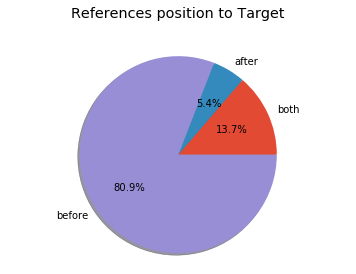

In [49]:
loc_c = Counter([target_before_after(x) for x in target_ref_tokens_order])

fig_agg, ax_agg = plt.subplots()

ax_agg.pie(loc_c.values(), labels=loc_c.keys(), autopct='%1.1f%%',
        shadow=True)
ax_agg.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('References position to Target', y=1.1)
# my_dpi=1200
# plt.savefig('../resources/cat-dist.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

### Nouns in Reference answers

In [50]:
SEP = '_SEP_'
nlp_n = spacy.load('en')
old_tokenizer = nlp_n.tokenizer
nlp_n.tokenizer = lambda string: old_tokenizer.tokens_from_list(string.split(SEP))

In [51]:
ref_sen = []
for ind, scene in tqdm_notebook(data_groups):
    target = scene[scene['head'] != '-']['head'].values
    if len(target) == 0:
        continue
    if target[0] != 'REFERENCE':
        continue
    words = scene['word'].tolist()
    ref_sen.append(nlp_n(unicode(SEP.join(words).decode('utf-8'))))

In [52]:
def num_nouns(sen):
    c = 0
    for w in sen:
        if w.pos_ == 'NOUN':
            c += 1
    return c

In [53]:
nouns_c = Counter([num_nouns(x) for x in ref_sen])

In [54]:
nouns_c

Counter({0: 12,
         1: 174,
         2: 284,
         3: 303,
         4: 337,
         5: 308,
         6: 282,
         7: 265,
         8: 229,
         9: 214,
         10: 177,
         11: 157,
         12: 141,
         13: 142,
         14: 137,
         15: 109,
         16: 124,
         17: 65,
         18: 84,
         19: 80,
         20: 53,
         21: 69,
         22: 91,
         23: 33,
         24: 64,
         25: 48,
         26: 38,
         27: 50,
         28: 28,
         29: 31,
         30: 30,
         31: 28,
         32: 28,
         33: 24,
         34: 20,
         35: 18,
         36: 24,
         37: 15,
         38: 14,
         39: 15,
         40: 14,
         41: 13,
         42: 16,
         43: 13,
         44: 15,
         45: 10,
         46: 11,
         47: 9,
         48: 9,
         49: 10,
         50: 10,
         51: 7,
         52: 7,
         53: 2,
         54: 9,
         55: 6,
         56: 6,
         57: 3,
         58: 8,
 

In [55]:
len(ref_sen)

4598